https://towardsdatascience.com/stacking-classifiers-for-higher-predictive-performance-566f963e4840

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

# Classifiers
from sklearn.svm import NuSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier # <- Here is our boy

# Used to ignore warnings generated from StackingCVClassifier
import warnings
warnings.simplefilter('ignore')

In [2]:
X, y = make_classification(n_samples = 1000, n_features = 30, n_informative = 5,
                           n_redundant = 15, n_repeated = 5, 
                           n_clusters_per_class = 2, class_sep = 0.5,
                           random_state = 1000, shuffle = False)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,
                                                    random_state = 1000)


In [4]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [5]:
classifier1 = SVC(C = 50, degree = 1, gamma = "auto", kernel = "rbf", probability = True)

# Initializing Multi-layer perceptron  classifier
classifier2 = MLPClassifier(activation = "relu", alpha = 0.1, hidden_layer_sizes = (10,10,10),
                            learning_rate = "constant", max_iter = 2000, random_state = 1000)

# Initialing Nu Support Vector classifier
classifier3 = NuSVC(degree = 1, kernel = "rbf", nu = 0.25, probability = True)

# Initializing Random Forest classifier
classifier4 = RandomForestClassifier(n_estimators = 500, criterion = "gini", max_depth = 10,
                                     max_features = "auto", min_samples_leaf = 0.005,
                                     min_samples_split = 0.005, n_jobs = -1, random_state = 1000)


In [6]:
sclf = StackingCVClassifier(classifiers = [classifier1, classifier2, classifier3, classifier4],
                            shuffle = False,
                            use_probas = True,
                            cv = 5,
                            meta_classifier = SVC(probability = True))

In [7]:
classifiers = {"SVC": classifier1,
               "MLP": classifier2,
               "NuSVC": classifier3,
               "RF": classifier4,
               "Stack": sclf}

In [8]:
for key in classifiers:
    # Get classifier
    classifier = classifiers[key]
    
    # Fit classifier
    classifier.fit(X_train, y_train)
        
    # Save fitted classifier
    classifiers[key] = classifier

In [12]:
results = pd.DataFrame()
for key in classifiers:
    # Make prediction on test set
    y_pred = classifiers[key].predict_proba(X_test)[:,1]

    # Save results in pandas dataframe object
    results[f"{key}"] = y_pred

# Add the test set to the results object
results["Target"] = y_test

SVC
SVC
MLP
MLP
NuSVC
NuSVC
RF
RF
Stack
Stack


In [11]:
results

,SVC,MLP,NuSVC,RF,Stack,Target
0,0.673877,9.036385e-01,0.648635,0.520728,0.719478,1
1,0.093378,3.513668e-03,0.061055,0.216235,0.044821,0
2,0.204990,5.826951e-03,0.126203,0.325367,0.084257,0
3,0.925986,9.998531e-01,0.944684,0.505410,0.795643,1
4,0.985476,9.999795e-01,0.992759,0.775430,0.918825,1
5,0.260224,3.798747e-03,0.186614,0.375159,0.120839,1
6,0.655150,9.789751e-01,0.633683,0.566246,0.758417,0
7,0.979931,5.090870e-01,0.982097,0.690751,0.885247,1
8,0.586671,9.999145e-01,0.546824,0.664438,0.804530,1
9,0.126925,7.405601e-05,0.083218,0.053216,0.023941,0


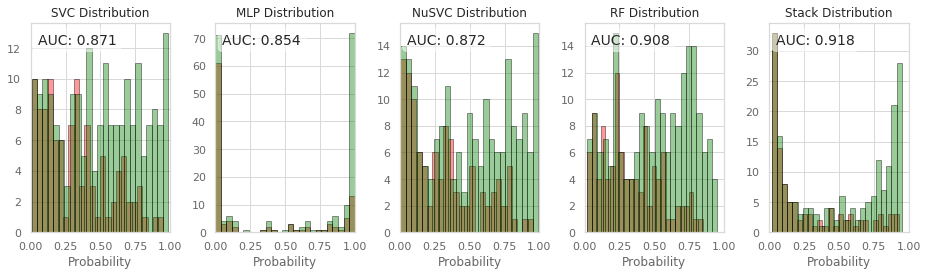

In [10]:
sns.set(font_scale = 1)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})

# Plot
f, ax = plt.subplots(figsize=(13, 4), nrows=1, ncols = 5)

for key, counter in zip(classifiers, range(5)):
    # Get predictions
    y_pred = results[key]
    
    # Get AUC
    auc = metrics.roc_auc_score(y_test, y_pred)
    textstr = f"AUC: {auc:.3f}"

    # Plot false distribution
    false_pred = results[results["Target"] == 0]
    sns.distplot(false_pred[key], hist=True, kde=False, 
                 bins=int(25), color = 'red',
                 hist_kws={'edgecolor':'black'}, ax = ax[counter])
    
    # Plot true distribution
    true_pred = results[results["Target"] == 1]
    sns.distplot(results[key], hist=True, kde=False, 
                 bins=int(25), color = 'green',
                 hist_kws={'edgecolor':'black'}, ax = ax[counter])
    
    
    # These are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    
    # Place a text box in upper left in axes coords
    ax[counter].text(0.05, 0.95, textstr, transform=ax[counter].transAxes, fontsize=14,
                    verticalalignment = "top", bbox=props)
    
    # Set axis limits and labels
    ax[counter].set_title(f"{key} Distribution")
    ax[counter].set_xlim(0,1)
    ax[counter].set_xlabel("Probability")
    
plt.tight_layout()

# Save Figure
plt.savefig("Probability Distribution for each Classifier.png", dpi = 1080)


In [11]:
params = {"meta_classifier__kernel": ["linear", "rbf", "poly"],
          "meta_classifier__C": [1, 2],
          "meta_classifier__degree": [3, 4, 5],
          "meta_classifier__probability": [True]}


# Initialize GridSearchCV
grid = GridSearchCV(estimator = sclf, 
                    param_grid = params, 
                    cv = 5,
                    scoring = "roc_auc",
                    verbose = 10,
                    n_jobs = -1)

# Fit GridSearchCV
grid.fit(X_train, y_train)

# Making prediction on test set
y_pred = grid.predict_proba(X_test)[:,1]

# Getting AUC
auc = metrics.roc_auc_score(y_test, y_pred)

# Print results
print(f"The AUC of the tuned Stacking classifier is {auc:.3f}")


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done  21 out of  90 | elapsed:   51.4s remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  31 out of  90 | elapsed:   53.4s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  41 out of  90 | elapsed:  1.5min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  51 out of  90 | elapsed:  1.6min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  61 out of  90 | elapsed:  1.7min remaining:   49.4s
[Parallel(n_jobs=-1)]: Done  71 out of  90 | elapsed:  1.8min remaining:   28.3s
[Parallel(n_jobs=-1)]: Done  81 out of  90 | elapsed:  2.1min remaining:   13.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.1min finished


The AUC of the tuned Stacking classifier is 0.922


In [12]:
classifier_labels = ["SVC", "MLP", "NuSVC", "RF"]

# Get all unique combinations of classifier with a set size greater than or equal to 2
combo_classifiers = []
for ii in range(2, len(classifier_labels)+1):
    for subset in itertools.combinations(classifier_labels, ii):
        combo_classifiers.append(subset)

# Stack, tune, and evaluate stack of classifiers
for combo in combo_classifiers:
    # Get labels of classifier to create a stack
    labels = list(combo)
     
    # Get classifiers
    classifier_combo = []
    for ii in range(len(labels)):
        label = classifier_labels[ii]
        classifier = classifiers[label]
        classifier_combo.append(classifier)
         
    # Initializing the StackingCV classifier
    sclf = StackingCVClassifier(classifiers = classifier_combo,
                                shuffle = False,
                                use_probas = True,
                                cv = 5,
                                meta_classifier = SVC(probability = True),
                                n_jobs = -1)
    
    # Initialize GridSearchCV
    grid = GridSearchCV(estimator = sclf, 
                        param_grid = params, 
                        cv = 5,
                        scoring = "roc_auc",
                        verbose = 0,
                        n_jobs = -1)
    
    # Fit GridSearchCV
    grid.fit(X_train, y_train)
    
    # Making prediction on test set
    y_pred = grid.predict_proba(X_test)[:,1]
    
    # Getting AUC
    auc = metrics.roc_auc_score(y_test, y_pred)
    
    # Print results
    print(f"AUC of stack {combo}: {auc:.3f}")

AUC of stack ('SVC', 'MLP'): 0.877
AUC of stack ('SVC', 'NuSVC'): 0.879
AUC of stack ('SVC', 'RF'): 0.877
AUC of stack ('MLP', 'NuSVC'): 0.877
AUC of stack ('MLP', 'RF'): 0.877
AUC of stack ('NuSVC', 'RF'): 0.877
AUC of stack ('SVC', 'MLP', 'NuSVC'): 0.879
AUC of stack ('SVC', 'MLP', 'RF'): 0.879
AUC of stack ('SVC', 'NuSVC', 'RF'): 0.876
AUC of stack ('MLP', 'NuSVC', 'RF'): 0.879
AUC of stack ('SVC', 'MLP', 'NuSVC', 'RF'): 0.922
